In [ ]:
!nvidia-smi

Mon Dec 14 20:02:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers # necessário para usar o Bert

     |████████████████████████████████| 1.4MB 8.0MB/s 
     |████████████████████████████████| 890kB 29.1MB/s 
     |████████████████████████████████| 2.9MB 19.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6390978690ba86c453857d37f66ee6c09469fec508ebf737226b1a7037d3c023
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install "nltk==3.5" # necessário para usar o meteor

     |████████████████████████████████| 1.4MB 7.6MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434676 sha256=bd1ea6a6122e1a8ed7be5c95299bc1788849f1b4015c739ea2b5d613b5fe57df
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import random

# BERT
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFBertForMaskedLM,
    TFTrainer,
    TFTrainingArguments,
    pipeline,
)

# Train test split
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm # necessário para mostrar a barra de progresso

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
nltk.download('wordnet') # necessário para usar o meteor

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
seed = 0
np.random.seed(seed)
random.seed(seed)

In [ ]:
CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
# EOS = '[EOS]'
EOS = '[unused99]'
SPC = ' '

# path = '../data/b2w-10k.csv'
# sep = ','
# percent = 1

# path = "https://raw.githubusercontent.com/feperessim/NLPortugues/master/Semana%2006/data/b2w-10k.csv"
# sep = ','
# percent = 1

# path = '../data/B2W-Reviews01.csv
# sep = ';'
# percent = 0.2

path = 'https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv'
sep = ';'
percent = 0.25

sns.set_theme()

In [ ]:
contraction_mapping = {'ñ' : 'não', 'n' : 'não', 'naum' : 'não', 's':'sim', 'vc' : 
                       'você', 'tbm' : 'também', 'tbn':'também', 'tb' : 'também', 
                       'kd' : 'cade', 'kade' : 'cade', 'kual' : 'qual', 'mt' : 'muito',
                       'msm' : 'mesmo', 'axo' : 'acho', 'q' : 'que', 'hj' : 'hoje', 
                       'blz' : 'beleza', 'ctz' : 'certeza', 'fikdik' : 'fica a dica',
                       'glr' : 'galera', 'msg' : 'mensagem', 'pfv' : 'por favor', 
                       'plmdds' : 'pelo amor de deus', 'pq' : 'porque', 'vdd' : 'verdade', 
                       'bosta' : 'ruim', 'merda' : 'ruim', 'abç' : 'abraço', 'bj' : 'beijo',
                       'bjs' : 'beijos', 't+' : 'até mais', 'eh' : 'é', 'aki' : 'aqui', 'ruin':'ruim'}

In [ ]:
def preprocess_sentence(sentence):
    '''
    Normalize preprocess a sequence of words
    in a sentence. 
    This function does the following:
    
    1 - Convert everything to lowercase;
        removes trailing and leading spaces
    
    2 - remove digits
    
    3 - Creates a space between a word and the
        punctuation following it;
        also, it replaces repetitions of
        punctuations by a single instance;
    
    4 - replaces informal contractions by 
        its equivalent formal word.
        
    5 - # replaces special symbols
        
    Add a start and end token to each sentence.
    
    Args:
        sentence - a human readable string
    returns:
        a string of preprocessed text
    '''
    # Convert to lower case; remove digits; 
    # and replace many dots by a single one
    # keep only words with length at most WORD_MAX_LEN
    sentence = sentence.lower().strip()
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # replace multiple punctuation by a single one
    # Reference: https://stackoverflow.com/questions/35041672/regex-replace-multiple-punctuation-in-python
    sentence = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", sentence)
    
    # creating a space between a word and the punctuation following it
    # eg: "ele é um menino." => "ele é um menino ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # replace contractions by the real word e.g vc - você
    sentence = ' '.join([contraction_mapping[word]
                         if word in contraction_mapping
                         else word for word in sentence.split(' ')])
    
    # replace special symbols
    sentence = re.sub('[!*)@#%(&$_^~]', '', sentence)
    
    sentence = sentence.strip()
    
    return sentence

In [ ]:
def tokenize(sentences, tokenizer=None, ref_model = None, maxlen=50, add_special_tokens=True):
    '''
    Encodes a string to an array of integers

    Args:
        sentences (list): list of human-readable strings to encode  
        tokenizer () : Bert tokenizer instance
        ref_model (str) : bert reference model
        maxlen (int) : max length of a sequence to pad and truncate
    Returns:
        (dict : numpy array) input_ids, token_type_ids, attention_mask
        Tokenizer: Bert tokenizer instance
    '''
    # Bert Tokenizer
    if tokenizer is None:
      tokenizer = BertTokenizer.from_pretrained(ref_model)
      tokenizer.eos_token = EOS
      # tokenizer = BertTokenizer.from_pretrained(ref_model, eos_token=EOS) # Não funciona a loss da nan
    
    # tokenizer.add_tokens([EOS]) # Não funciona a loss da nan
    
    encoded = tokenizer(
        [[line] for line in sentences],
        text_pair=None,
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_tensors='np',
        add_special_tokens=add_special_tokens)
    
    return encoded, tokenizer

In [ ]:
def create_dataset(x, y):
    '''
    Apply the transformations in
    the function preprocess_sentence
    to every line of text in x and y
    Args:
        x, y - list of human readable strings
    returns:
        list of human readable strings preprocessed
    '''
    return ([preprocess_sentence(sentence) for sentence in x],
            [preprocess_sentence(sentence) for sentence in y])

In [ ]:
def load_dataset_and_preprocess(path='../data/b2w-10k.csv', sep=',', percent=1):
    '''
    creating cleaned input, output pairs of
    length at most SEQUENCE_MAXLEN
    Args:
        path (string) : full path to the dataset
    returns:
        (list of strings, list of strings): text and title 
        lists of strings
    '''
    usecols = ["review_text", "review_title"]
    
    dataset = pd.read_csv(path, usecols=usecols, sep=sep, error_bad_lines=False)
    if percent != 1:
      dataset = dataset.sample(frac=percent)
    # dropping duplicates and dropping na
    dataset.drop_duplicates(subset=['review_text'], inplace=True)
    dataset.dropna(axis=0,inplace=True)
    
    # dropping sentences with length <= 2
    dataset = dataset[dataset['review_text'].apply(len) > 2]
    dataset = dataset[dataset['review_title'].apply(len) > 2]

    text, title = create_dataset(dataset["review_text"].values, dataset["review_title"].values)
    
    return text, title

In [ ]:
def generate_pairs(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate pairs for summary task
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        pairs (list of strings, list of strings) : pairs with lists of strings of 
        text and title 
    '''
    pairs = []
    text_truncated = ' '.join(text.split()[:text_max_nb_words])
    title_truncated = ' '.join(title.split()[:title_max_nb_words]) + SPC + EOS + SPC
    spl = title_truncated.split()

    for w in range(len(spl)):
        # new_text = CLS + SPC + text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK + SPC + SEP
        new_text = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK
        # pairs.append([new_text, spl[w]])
        new_output = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + spl[w]
        pairs.append([new_text, new_output])
        
    return pairs

In [ ]:
def generate_samples(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate samples for summary task - helper function
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        (text, title) (list of strings, list of strings) :  samples
    '''
    new_text = []
    new_title = []
    
    for i in range(len(text)):
        pairs = generate_pairs(text[i], title[i], text_max_nb_words, title_max_nb_words)
        new_text.extend([sample[0] for sample in pairs])
        new_title.extend([sample[1] for sample in pairs])
    
    return new_text, new_title

In [ ]:
def predict_and_decode_sequences(data, model, sent_max_len, sent_max_nb_words, seq_max_len, tokenizer):
  '''
  Predicts the title review given
  a text review sentence.
  args:
    data (list:str) or (numpy array:str) - list/array 
    of human readable strings

    model (keras model) : keras model used to predict
    the sentence title review
    
    sent_max_len (int) : max number of characters of the
    predicted sentence

    sent_max_nb_words (int) : max number of words of the
    predicted sentence

    seq_max_len (int) : sequence max length

    tokenizer (Bert pretreined tokenizer) - Bert tokenizer

  returns:
    sentences (list:str) : list of predicted titles
  '''

  sentences = []
  with tqdm(total=len(data)) as pbar:
    for sentence in data:
      next_sent = ' '.join(sentence.split()[:sent_max_nb_words]) + SPC + SEP + MASK
      result = ''
      predicted_word = ''

      while len(result) <= sent_max_len and predicted_word != EOS:
        # Tokenize sentence and get the index of [MAK]
        # tokenized_sent = tok(next_sent)
        tokenized_sent, _ = tokenize([next_sent], tokenizer, maxlen=seq_max_len)
        mask_idx = np.where(tokenized_sent['input_ids'][0] == tokenizer.mask_token_id)[0]
        if len(mask_idx) == 0:
          break
        mask_idx = mask_idx[0]
        # Make prediction and get the word indexes
        pred = model.predict([tokenized_sent['input_ids'], tokenized_sent["attention_mask"]])
        prediction = np.argmax(pred.logits, axis=-1)
        # decode predicted sequence to human readable string
        new_sent = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(prediction[0][0:mask_idx]))
        predicted_word = tokenizer.ids_to_tokens[int(prediction[0][mask_idx-1])]

        if predicted_word != EOS:
          result = result + predicted_word + ' '
        # make the new sentence ready for a new prediction
        next_sent = new_sent + SPC + MASK
      sentences.append(result.strip())
      pbar.update(1)
  return sentences

In [ ]:
def compute_bleu(titles_real, titles_pred):
    '''
    Args:
        titles_real (tensor:str) : array of real titles review
        titles_pred (tensor:str) : array of predicted titles review
    returns:
        scores (tensor) : bleu scores for each sentence of text tensor
    '''
    scores = []
    with tqdm(total=len(titles_real)) as pbar:
      for index in range(len(titles_real)):
          reference = titles_real[index]
          candidate = titles_pred[index]
          score = sentence_bleu([reference], candidate)
          scores.append(score)
          pbar.update(1)
    return scores

In [ ]:
def compute_meteor(titles_real, titles_pred):
    '''
     Args:
        titles_real (tensor:str) : array of real titles review
        titles_pred (tensor:str) : array of predicted titles review
    returns:
        scores (tensor) : meteor scores for each sentence of text tensor
    '''
    scores = []
    with tqdm(total=len(titles_real)) as pbar:
      for index in range(len(titles_real)):
          reference = titles_real[index]
          candidate = titles_pred[index]
          if reference != '' and candidate != '':
              score = meteor_score([reference], candidate)
              scores.append(score)
          pbar.update(1)
    return scores

In [ ]:
def plot_dist_sentences(text, title):
    '''
    Plots the sentences distributions
    Args:
        text, title - list preprocessed strings
    returns:
        list of human readable strings preprocessed
    '''
    text_word_count = []
    title_word_count = []

    # populate the lists with sentence lengths
    for i in text:
          text_word_count.append(len(i.split()))

    for i in title:
          title_word_count.append(len(i.split()))

    fig = plt.figure(figsize = (15,5))

    ax = fig.gca()

    length_df = pd.DataFrame({'Text review':text_word_count, 'Title review':title_word_count})
    length_df.hist(bins = [i for i in range(0, 105, 5)], ax=ax)

    # set title and axis labels
    plt.suptitle('Distribuição da quantidade de palavras por sentença', x=0.5, y=1.05, ha='center', fontsize='xx-large')
    fig.text(0.5, 0.04, 'Quantidade de palavras por sentença', ha='center')
    fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')

    plt.show()

In [ ]:
def plot_loss(history, filename='', save=False):
    '''
    Input:
        history (dict) : keras history instance
        filename (string) : filename to save
        save (boolean) : to choose save the plot
    Output:
       None
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    nb_epochs = len(loss)
  
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 

    plt.figure(figsize=(20,10))
    plt.xlabel(str(nb_epochs) + ' Epochs', **font)
    plt.ylabel('Loss', **font)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', **title_font)
    plt.legend()
    if save:
        plt.savefig('../rel/figuras/' + filename + 'loss.png')
    plt.show()

In [ ]:
def plot_acc(history, filename='', save=False):
    '''
    Input:
        history (dict) : keras history instance
        filename (string) : filename to save
        save (boolean) : to choose save the plot
    Output:
       None
    '''
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    nb_epochs = len(accuracy)
  
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}
    title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 

    plt.figure(figsize=(20,10))
    plt.xlabel(str(nb_epochs) + ' Epochs', **font)
    plt.ylabel('Accuracy', **font)
    plt.plot(epochs, accuracy, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc', **title_font)
    plt.legend()
    if save:
        plt.savefig('../rel/figuras/' + filename + 'acc.png')
    plt.show()

# Carregar e preprocessar o dataset

Aqui o dataset é carregado e preprocessado.

In [ ]:
text_train, title_train = load_dataset_and_preprocess(path, sep, percent)

# Distribuição do texto
A distribuição é analisada para se determinar o tamanho máximo das sentenças.

Obs: Espaços não são contabilizados

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


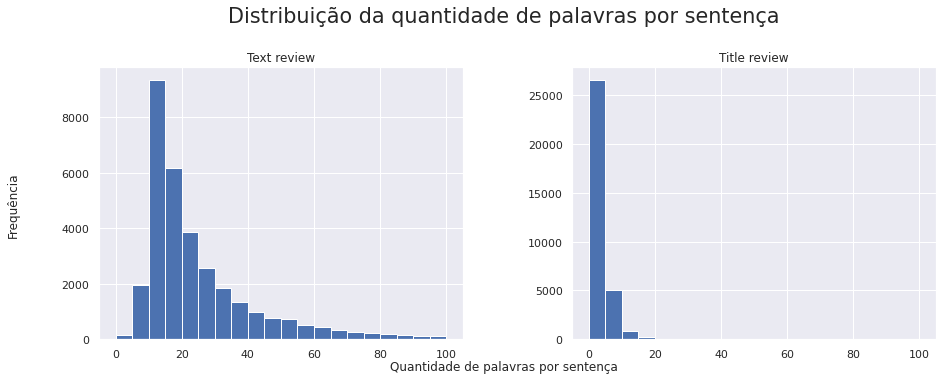

In [ ]:
plot_dist_sentences(text_train, title_train)

In [ ]:
TEXT_MAXLEN = 64
TITLE_MAXLEN = 15

TEXT_MAX_NB_WORDS = 15
TITLE_MAX_NB_WORDS = 5

# Separando os dados em conjuntos de treino, validação e teste

Separamos os conjuntos em conjuntos de treino, validação e de testes com proporções 80%, 10%, 10%. 

In [ ]:
text_train, text_val, title_train, title_val = train_test_split(text_train, title_train, test_size=0.2,random_state=seed, shuffle=True)
text_val, text_test, title_val, title_test = train_test_split(text_val, title_val, test_size=0.5,random_state=seed,shuffle=True)

# Criando cópia do conjunto de testes para inferência do decoder

In [ ]:
text_test_inf = text_test.copy()
title_test_inf  = title_test.copy()

# Preparando o dataset para o Bert

Aqui a função <i>generate_samples</i> prepara as amostras para treinar o bert.

In [ ]:
text_train, title_train = generate_samples(text_train, title_train, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
text_val, title_val = generate_samples(text_val, title_val, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
text_test, title_test = generate_samples(text_test, title_test, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)

# Tokenização

In [ ]:
SEQUENCE_MAXLEN = TEXT_MAXLEN + TITLE_MAXLEN + 2
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'

text_train, text_train_tokenizer = tokenize(text_train, None, REF_MODEL, SEQUENCE_MAXLEN)
text_val, _ = tokenize(text_val, text_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)
text_test, _ = tokenize(text_test, text_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)

title_train, title_train_tokenizer = tokenize(title_train, None, REF_MODEL, SEQUENCE_MAXLEN, False)
title_val, _ = tokenize(title_val, title_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)
title_test, _ = tokenize(title_test, title_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)

In [ ]:
print('Shapes dos conjuntos após realizar todas as etapas necessárias')
print()
print('TEXT')
print('=======================')
print('Train:', text_train['input_ids'].shape)
print('Val:  ', text_val['input_ids'].shape)
print('Test: ', text_test['input_ids'].shape)
print('=======================')
print()
print('TITLE:')
print('=======================')
print('Train: ', title_train['input_ids'].shape)
print('Val:   ', title_val['input_ids'].shape)
print('Test   ', title_test['input_ids'].shape)
print('=======================')

Shapes dos conjuntos após realizar todas as etapas necessárias

TEXT
Train: (98155, 81)
Val:   (12204, 81)
Test:  (12326, 81)

TITLE:
Train:  (98155, 81)
Val:    (12204, 81)
Test    (12326, 81)


# Tamanho do vocabulário

Aqui definimos os tamanhos dos vocabulários do text review e title review

In [ ]:
TEXT_VOC_SIZE = len(text_train_tokenizer.get_vocab())
TITLE_VOC_SIZE = len(title_train_tokenizer.get_vocab())

In [ ]:
print('Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas')
print()
print('=======================')
print('Text:', TEXT_VOC_SIZE, 'palavras')
print('=======================')
print()
print('=======================')
print('Title:', TITLE_VOC_SIZE, 'palavras')
print('=======================')

Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas

Text: 29794 palavras

Title: 29794 palavras


# Construção do modelo BERT

In [ ]:
bert_model = TFBertForMaskedLM.from_pretrained(REF_MODEL, from_pt=True)
input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')

X = bert_model(input_ids, input_masks_ids)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

# Treinamento do Modelo

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-07)
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)]
model.compile(opt, loss, metrics=[metric])

In [ ]:
bert_model.summary()

Model: "tf_bert_for_masked_lm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 108923136 
_________________________________________________________________
mlm___cls (TFBertMLMHead)    (None, 81, 29794)         23900002  
Total params: 109,545,058
Trainable params: 109,545,058
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 81)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 81)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_masked_lm (TFBertFo TFMaskedLMOutput(los 109545058   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 109,545,058
Trainable params: 109,545,058
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
EPOCHS = 4
BATCH_SIZE = 64

In [ ]:
history = model.fit(
    [text_train["input_ids"],
     text_train["attention_mask"]],
    title_train["input_ids"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_data = ([text_val["input_ids"],
                       text_val["attention_mask"]],
                       title_val["input_ids"])
)    

Epoch 1/4
1534/1534 [==============================] - 2308s 2s/step - loss: 0.4596 - accuracy: 0.9274 - val_loss: 0.0606 - val_accuracy: 0.9895
Epoch 2/4
1534/1534 [==============================] - 2306s 2s/step - loss: 0.0641 - accuracy: 0.9888 - val_loss: 0.0536 - val_accuracy: 0.9903
Epoch 3/4
1534/1534 [==============================] - 2311s 2s/step - loss: 0.0562 - accuracy: 0.9898 - val_loss: 0.0505 - val_accuracy: 0.9905
Epoch 4/4
1534/1534 [==============================] - 2306s 2s/step - loss: 0.0525 - accuracy: 0.9901 - val_loss: 0.0492 - val_accuracy: 0.9906


# Avaliação conjunto de testes

In [ ]:
model.evaluate([text_test["input_ids"],
                text_test["attention_mask"]], 
               title_test["input_ids"])

386/386 [==============================] - 106s 276ms/step - loss: 0.0500 - accuracy: 0.9906


[0.05003812164068222, 0.9905619621276855]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


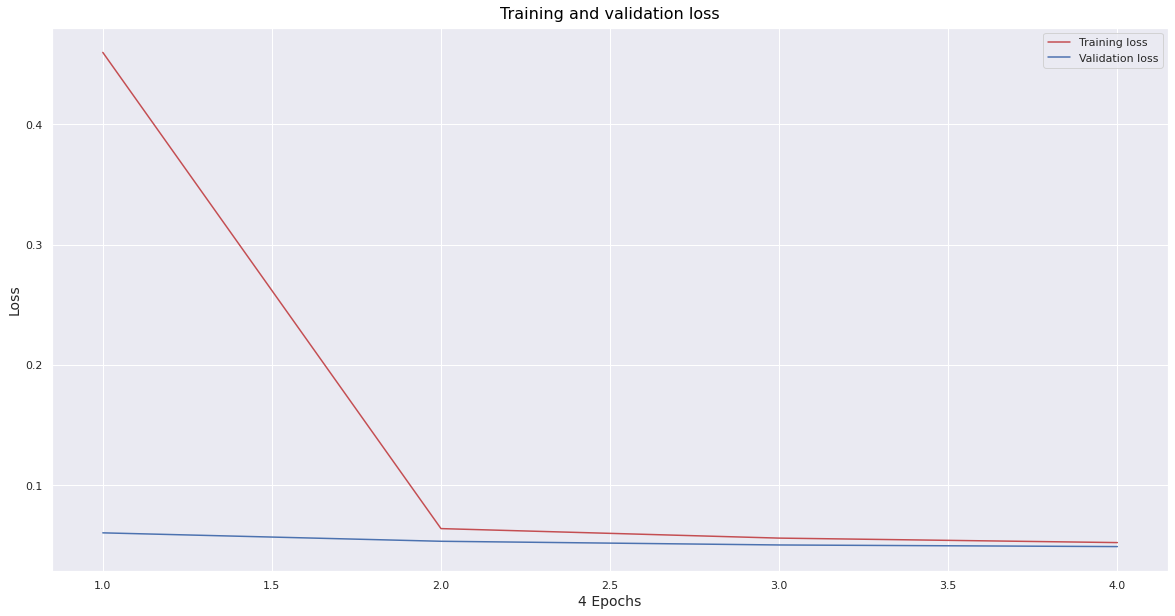

In [ ]:
plot_loss(history, filename='', save=False)

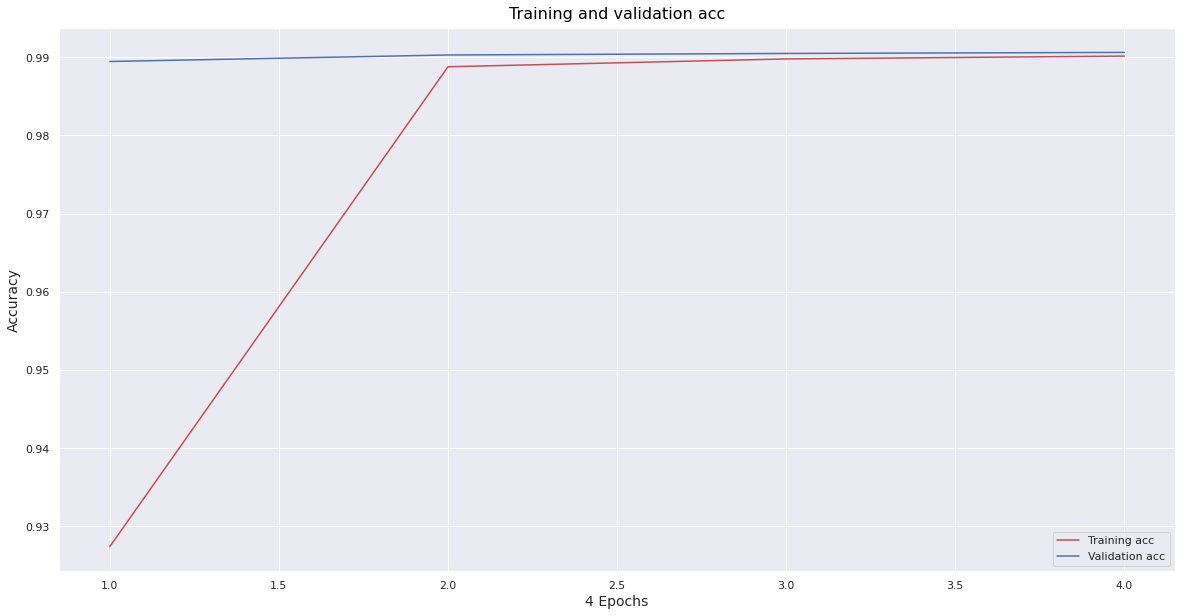

In [ ]:
plot_acc(history, filename='', save=False)

# Previsão de títulos para inferência das métricas

Aqui usamos as sentenças do text review do conjunto de testes para prever os títulos que serão usados posteriormente na computação das métricas BLEU e METEOR.

In [ ]:
titles_pred = predict_and_decode_sequences(text_test_inf, model, TITLE_MAXLEN, TEXT_MAX_NB_WORDS, SEQUENCE_MAXLEN, text_train_tokenizer)

# Computação das métricas

# Bleu

In [ ]:
print("Computando o Bleu para ", len(text_test_inf), "sentenças")
print()
scores_bleu = compute_bleu(title_test_inf, titles_pred)
print("Min:", round(np.min(scores_bleu), 4), '\n')
print("Média:", round(np.mean(scores_bleu), 4), '\n')
print("Max:", round(np.max(scores_bleu), 4), '\n')
print("Desvio Padrão:", round(np.std(scores_bleu), 4), '\n')
print("Variância:", round(np.var(scores_bleu), 4), '\n')
print("Coeficiente de Variação:", round(np.std(scores_bleu)/np.mean(scores_bleu) * 100, 4), '\n')
print()

Computando o Bleu para  3268 sentenças



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg


Min: 0.0 

Média: 0.0966 

Max: 1.0 

Desvio Padrão: 0.2065 

Variância: 0.0426 

Coeficiente de Variação: 213.8198 




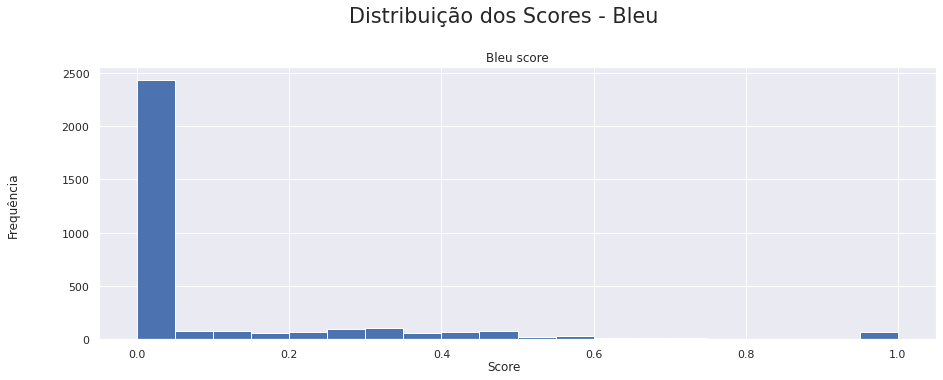

In [ ]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()

length_df = pd.DataFrame({'Bleu score':scores_bleu})
length_df.hist(bins = 20, ax=ax)

# set title and axis labels
plt.suptitle('Distribuição dos Scores - Bleu', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Score', ha='center')
fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')
plt.show()

# Meteor

In [ ]:
print("Computando o Meteor para ", len(text_test_inf), "sentenças")
print()
scores_meteor = compute_meteor(title_test_inf, titles_pred)
print("Min:", round(np.min(scores_meteor), 4), '\n')
print("Média:", round(np.mean(scores_meteor),4), '\n')
print("Max:", round(np.max(scores_meteor), 4), '\n')
print("Desvio Padrão:", round(np.std(scores_meteor), 4), '\n')
print("Variância:", round(np.var(scores_meteor), 4), '\n')
print("Coeficiente de Variação:", round(np.std(scores_meteor)/np.mean(scores_meteor) * 100, 4), '\n')
print()

Computando o Meteor para  3268 sentenças




Min: 0.0 

Média: 0.0698 

Max: 0.9922 

Desvio Padrão: 0.1583 

Variância: 0.0251 

Coeficiente de Variação: 226.8218 




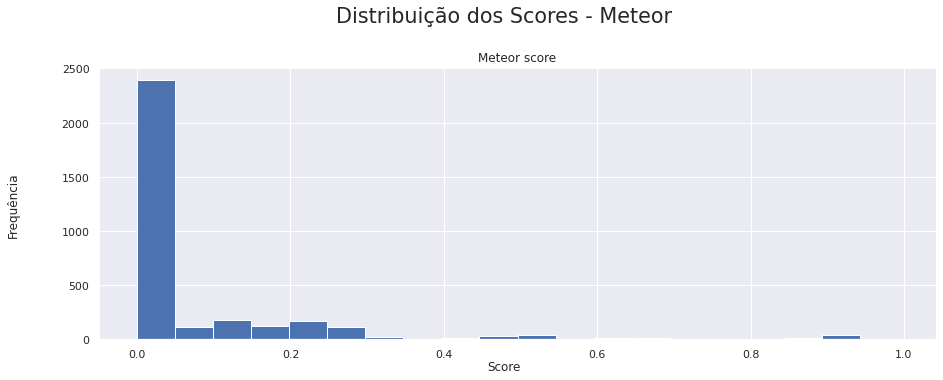

In [ ]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()

length_df = pd.DataFrame({'Meteor score':scores_meteor})
length_df.hist(bins = 20, ax=ax)

# set title and axis labels
plt.suptitle('Distribuição dos Scores - Meteor', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Score', ha='center')
fig.text(0.04, 0.5, 'Frequência', va='center', rotation='vertical')
plt.show()

# Exemplo de geração de texto com o modelo treinado usando o conjunto de testes

In [ ]:
for i in range(200, 230):
    print("Text Review:", text_test_inf[i])
    print("Original Title Review:", title_test_inf[i])
    print("Predicted Title Review:", titles_pred[i])
    print("\n")

Text Review: o produto nunca foi entregue no endereço informado
Original Title Review: o produto nao chegou
Predicted Title Review: não receb ##i o


Text Review: ótimo produto . só achei muito barulhento . poderiam melhorar esse quesito . mas de resto é excelente , boa potencia . recomendo .
Original Title Review: gostei muito do produto . como eu esperava
Predicted Title Review: ótimo produto


Text Review: ótimo produto e a entrega muito antes do prazo estipulado .
Original Title Review: ótimo produto .
Predicted Title Review: ótimo produto


Text Review: não utilizei ele ainda , porém a entrega foi no prazo determinado e o produto é lindo  adorei
Original Title Review: amei
Predicted Title Review: não gos gos muito


Text Review: o produto acima destacado chegou com vários pontos destacados e se espedaçando ao ser manuseado . fica claramente perceptível a má qualidade do material . sugiro que as lojas americanas não trabalhem com produtos com esse nível de qualidade , para que o co

# Para gerar um Title review use a função <i>predict_and_decode_sequences</i>

In [ ]:
sentences = ['Coloque suas frases aqui', 'é ruim', 'não chegou', 'Produto']
result = predict_and_decode_sequences(sentences, model, TITLE_MAXLEN, TEXT_MAX_NB_WORDS, SEQUENCE_MAXLEN, title_train_tokenizer)

for title_review in result:
    print(title_review + '\n')


ótimo

ruim

não chegou

excelente



# Vamos salvar 200 previsões de sentenças aleatórias para avaliação

In [ ]:
N = 200

indexes = [i for i in range(len(title_test_inf))]
random_indexes = random.sample(indexes, N)

text_review = np.array(text_test_inf)[random_indexes]
pred_title_review = np.array(titles_pred)[random_indexes]

human_score = [0] * N

df = pd.DataFrame({'Text Review' : text_review, 
                   'Predicted Title Review' : pred_title_review,
                   'Human Score': [0] * N})
                  
df.to_csv('bert_human_review.csv', index=False)